In [1]:
import os, glob, json
from copy import deepcopy
import numpy as np
import pandas as pd
import corner
import h5py
import prospect.io.read_results as reader
from prospect.plotting import FigureMaker
from prospect.plotting.utils import best_sample
from sedpy import observate

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import dataframe_image as dfi

from scipy.stats import gaussian_kde
from scipy.stats import kendalltau as kt

import astropy.constants as const
from astropy import units as u

vvColor = '#59594a'
myColor = '#a9bcd0'

In [2]:
sns.set(context='poster', style='white', palette='Set1')
plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.sans-serif"] = ['Liberation Sans']
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3

In [3]:
def computeConfidenceIntervals(result, alphas=[0.682, 0.954, 0.996], **kwargs):
    '''
    result dictionary from prospector
    '''
    chain, labels = result['chain'], result['theta_labels']
    return {str(a):CI(chain, labels, a, **kwargs) for a in alphas}                                        


def CI(chain, labels, alpha, verbose=False, log=None):
    '''
    Calculate the confidence intervals around the median
    of each input parameter in the chain
    
    chain [Array] : np array of output samples from the MCMC
    alpha [float] : confidence level to compute
    center [string] : techniique to get central value of distribution
                      that the CI is based around. Supported options are
                      'median', 'mode', 'mean'
    '''
    
    if log is None:
        log = [False]*len(labels) # don't log any of the labels
    
    forFile = 'Confidence Intervals: \n\n'
    outdict = {}
    for col, label, isLogged in zip(chain.T, labels, log):
        
        if isLogged:
            col = np.log10(col)
            label = f'log10({label})'
        
        middle = 0.5
        q1 = np.quantile(col, middle-(alpha/2))
        q2 = np.quantile(col, middle)
        q3 = np.quantile(col, middle+(alpha/2))
        
        forFile += f'{label} {alpha*100}% CI:\n'
        if verbose:
            forFile += f'         Q1: {q1}\n'
            forFile += f'Q2 (median): {q2}\n'
            forFile += f'         Q3: {q3}\n'
        forFile += f'{label} = {q2} (+{q3-q2}, -{q2-q1})'
        forFile += '\n'
        
        outdict[label] = {'median':q1,
                          'negErr':q2-q1,
                          'posErr':q3-q2}
        
    #print(forFile)
    
    return outdict 

In [4]:
outdir = os.path.join(os.getcwd(), 'data', 'out', '*h5')
outfiles = glob.glob(outdir)

allci = {}
allResults = {}
allObs = {}
alldata = {}
for h5file in outfiles:
    res, obs, model = reader.results_from(h5file)
    #cfig = reader.subcorner(res, logify=['mass', 'tau'], bins=20, smooth=1, color='darkred', 
    #                        title_kwargs=dict(fontsize=14), labelpad=0.1)
    #cfig.suptitle(obs['objid'], fontsize=18)
    
    #fig = reader.traceplot(res)
    #fig.suptitle(obs['objid'], fontsize=18)
    
    # compute some stats
    log = [True, False, False, False, False]
    ci = computeConfidenceIntervals(res, log=log)
    
    allci[obs['objid']] = ci
    allResults[obs['objid']] = res
    allObs[obs['objid']] = obs
    alldata[obs['objid']] = {label:chain for label, chain in zip(res['theta_labels'], np.median(res['chain'], axis=0).T)}

## Plot a host galaxy light curve

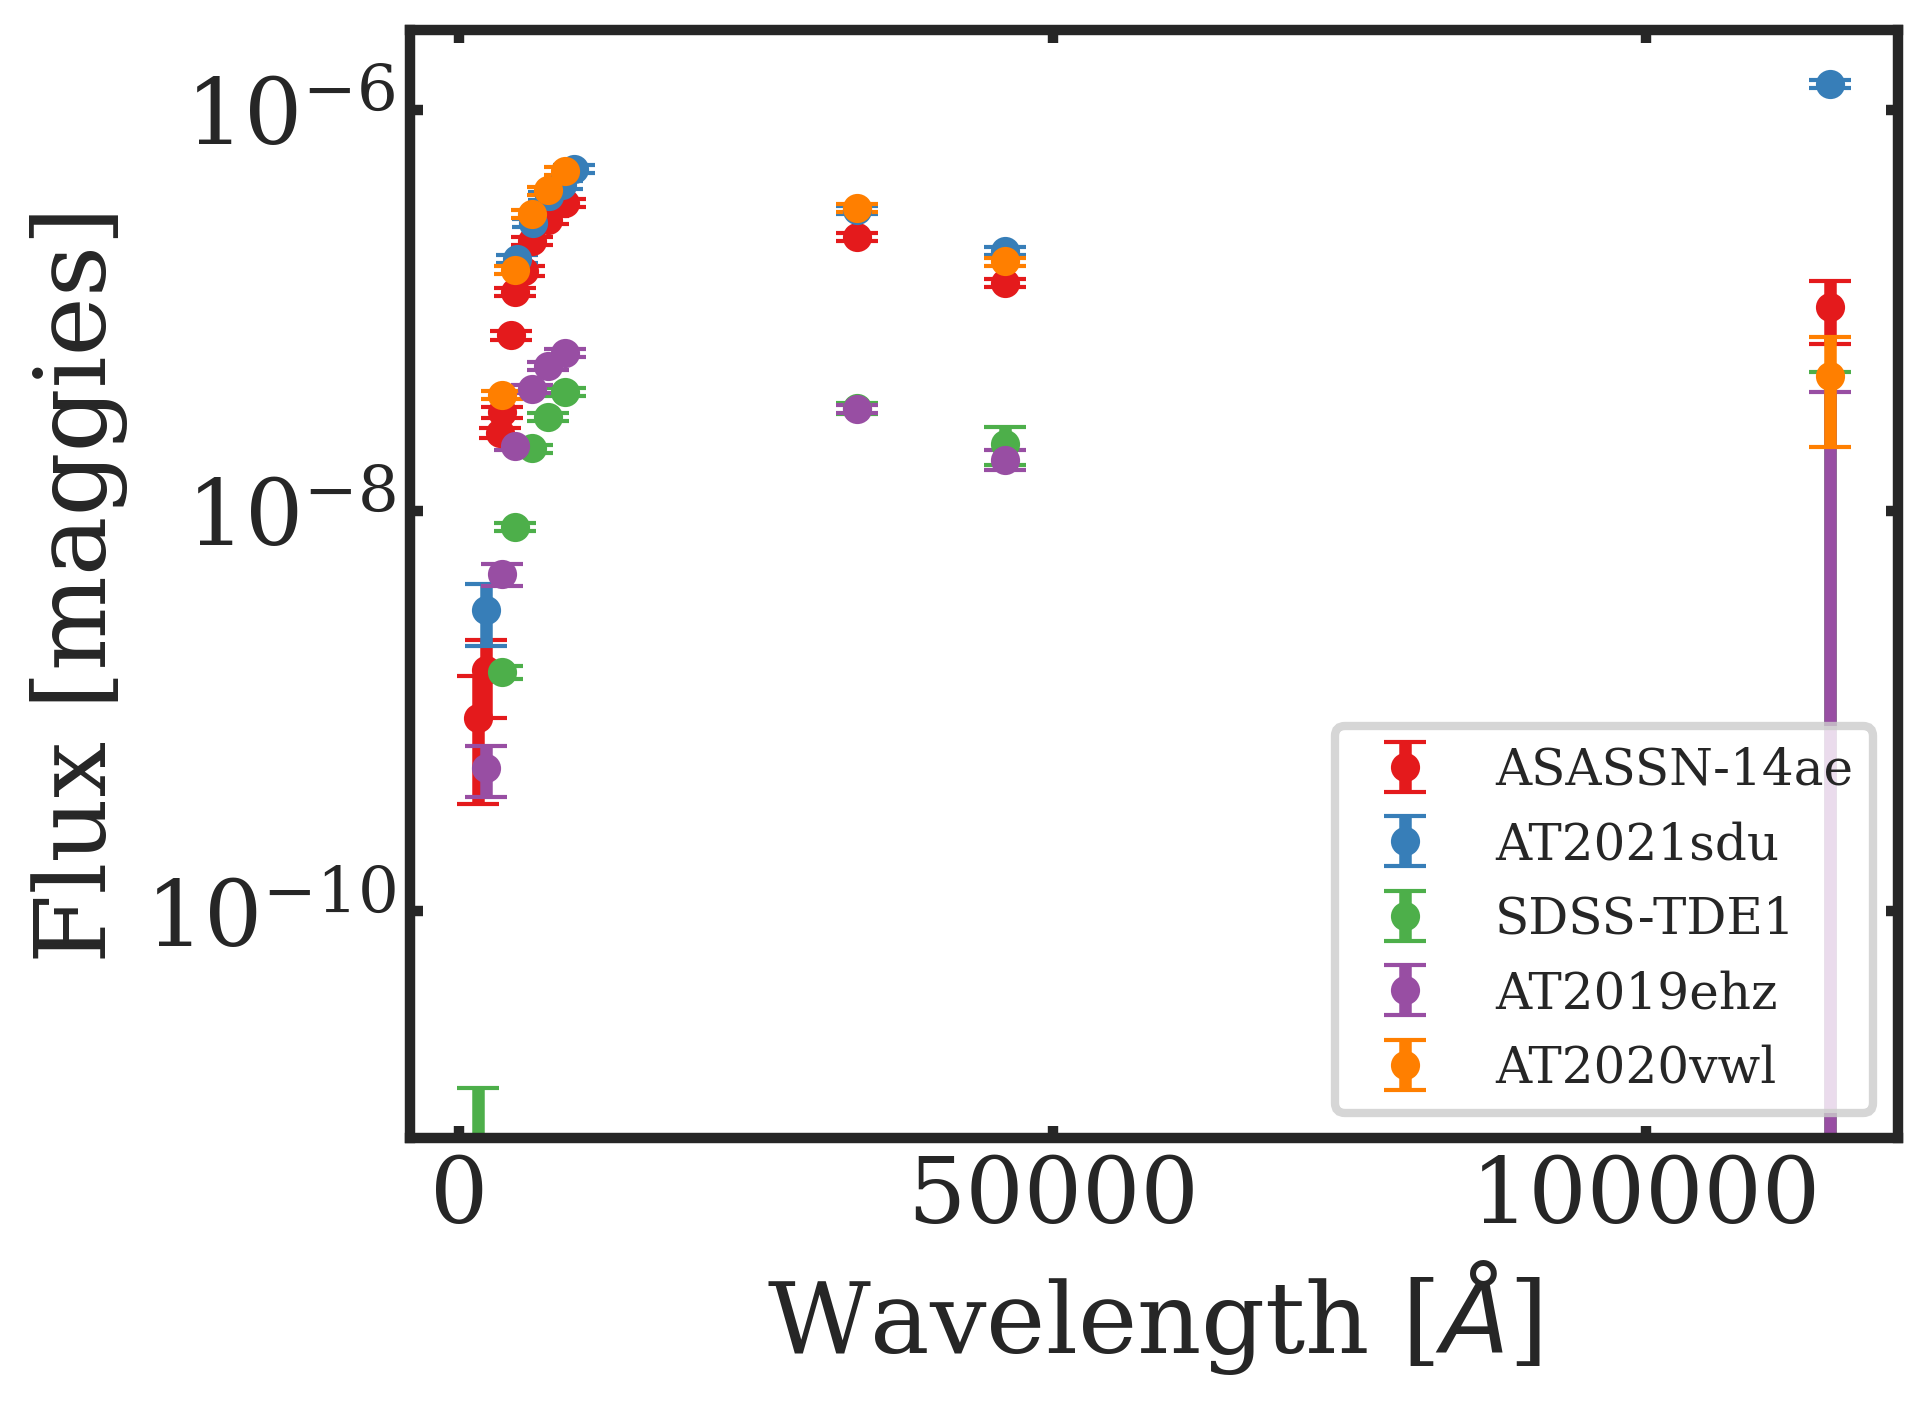

In [37]:
# read in a sample host galaxy json file
jsons = glob.glob('data/hostdata/*.json')

idx = list(range(4,9)) # change this to change the light curve

fig, ax = plt.subplots()

for i in idx:
    with open(jsons[i]) as j:
        data = json.load(j)
    
    
    data['filters'] = observate.load_filters(data['filternames'])
    data['wave_eff'] = [f.wave_effective for f in data['filters']]
    
    ax.errorbar(data['wave_eff'], data['maggies'], yerr=(data['maggies_unc']), fmt='.', capsize=5, label=os.path.basename(jsons[i]).split('.')[0])
ax.set_yscale('log')

ax.set_ylabel('Flux [maggies]')
ax.set_xlabel(r'Wavelength [$\AA$]')

ax.legend(fontsize=12);

## Comparing Median Values

In [90]:
subdict = {'median':[],
            'negErr_1s':[],
             'posErr_1s':[],
          'negErr_2s':[],
             'posErr_2s':[],
          'negErr_3s':[],
             'posErr_3s':[],
          'data': []
          }

dfdict = {'log10(mass)':deepcopy(subdict),
          'logzsol':deepcopy(subdict),
          'dust2':deepcopy(subdict),
          'tage':deepcopy(subdict),
          'tau':deepcopy(subdict),
          'names':[]}

cis = ['0.682', '0.954', '0.996']
for tde in allci:
    for key in dfdict:
        if key == 'names':
            dfdict[key].append(tde)
        else:
            for subkey in subdict:
                
                if '1s' in subkey:
                    ci = cis[0]
                    allci_subkey = subkey.split('_')[0]
                elif '2s' in subkey:
                    ci = cis[1]
                    allci_subkey = subkey.split('_')[0]
                elif '3s' in subkey:
                    ci = cis[2]
                    allci_subkey = subkey.split('_')[0]
                else:
                    ci = cis[0] # just take the median from the 1sig calc
                    allci_subkey = 'median'
                
                dfdict[key][subkey].append(allci[tde][ci][key][allci_subkey])

In [91]:
for key in dfdict:
    if key == 'names': continue
    dfdict[key] = pd.DataFrame(dfdict[key])
    dfdict[key]['name'] = dfdict['names']

In [92]:
subdict = {'median':[],
            'negErr':[],
             'posErr':[],
          }

true = {'true_mass':deepcopy(subdict),
       'true_z': deepcopy(subdict),
       'true_dust': deepcopy(subdict),
       'true_age': deepcopy(subdict),
       'true_tau': deepcopy(subdict),
       'name':[]}

truedata = pd.read_csv('data/catalog.txt', skiprows=6, delimiter='\t', 
                       names=['name', 'true_mass', 'u_r', 'true_dust', 'true_age', 'true_tau', 'true_z'],
                       usecols=range(7),
                      index_col=None)

for key in true:
    for val in truedata[key]:
        
        if key == 'name':
            true['name'].append(val)
            continue
        
        split1 = val.split('_')
        split2 = split1[1].split('^')

        med = split1[0][2:-1]
        if med[0] == '{':
            med = float(med.replace('{', '-'))
        else:
            med = float(med)

        upper = float(split2[0][1:-1])
        lower = float(split2[1][1:-2])
        
        true[key]['median'].append(med)
        true[key]['negErr'].append(lower)
        true[key]['posErr'].append(upper)

for key in true:
    if key == 'name': continue
    true[key] = pd.DataFrame(true[key])
    true[key]['name'] = true['name']    

In [93]:
true.keys(), dfdict.keys()

(dict_keys(['true_mass', 'true_z', 'true_dust', 'true_age', 'true_tau', 'name']),
 dict_keys(['log10(mass)', 'logzsol', 'dust2', 'tage', 'tau', 'names']))

In [94]:
comb = {}
keys = ['log10(Mass)', 'Z', 'Dust', 'Age', 'tau']
for d, t, key in zip(dfdict.values(), true.values(), keys):
    df = pd.merge(d, t, on='name', suffixes=['_Franz', '_vanVelzen']) 
    comb[key] = df

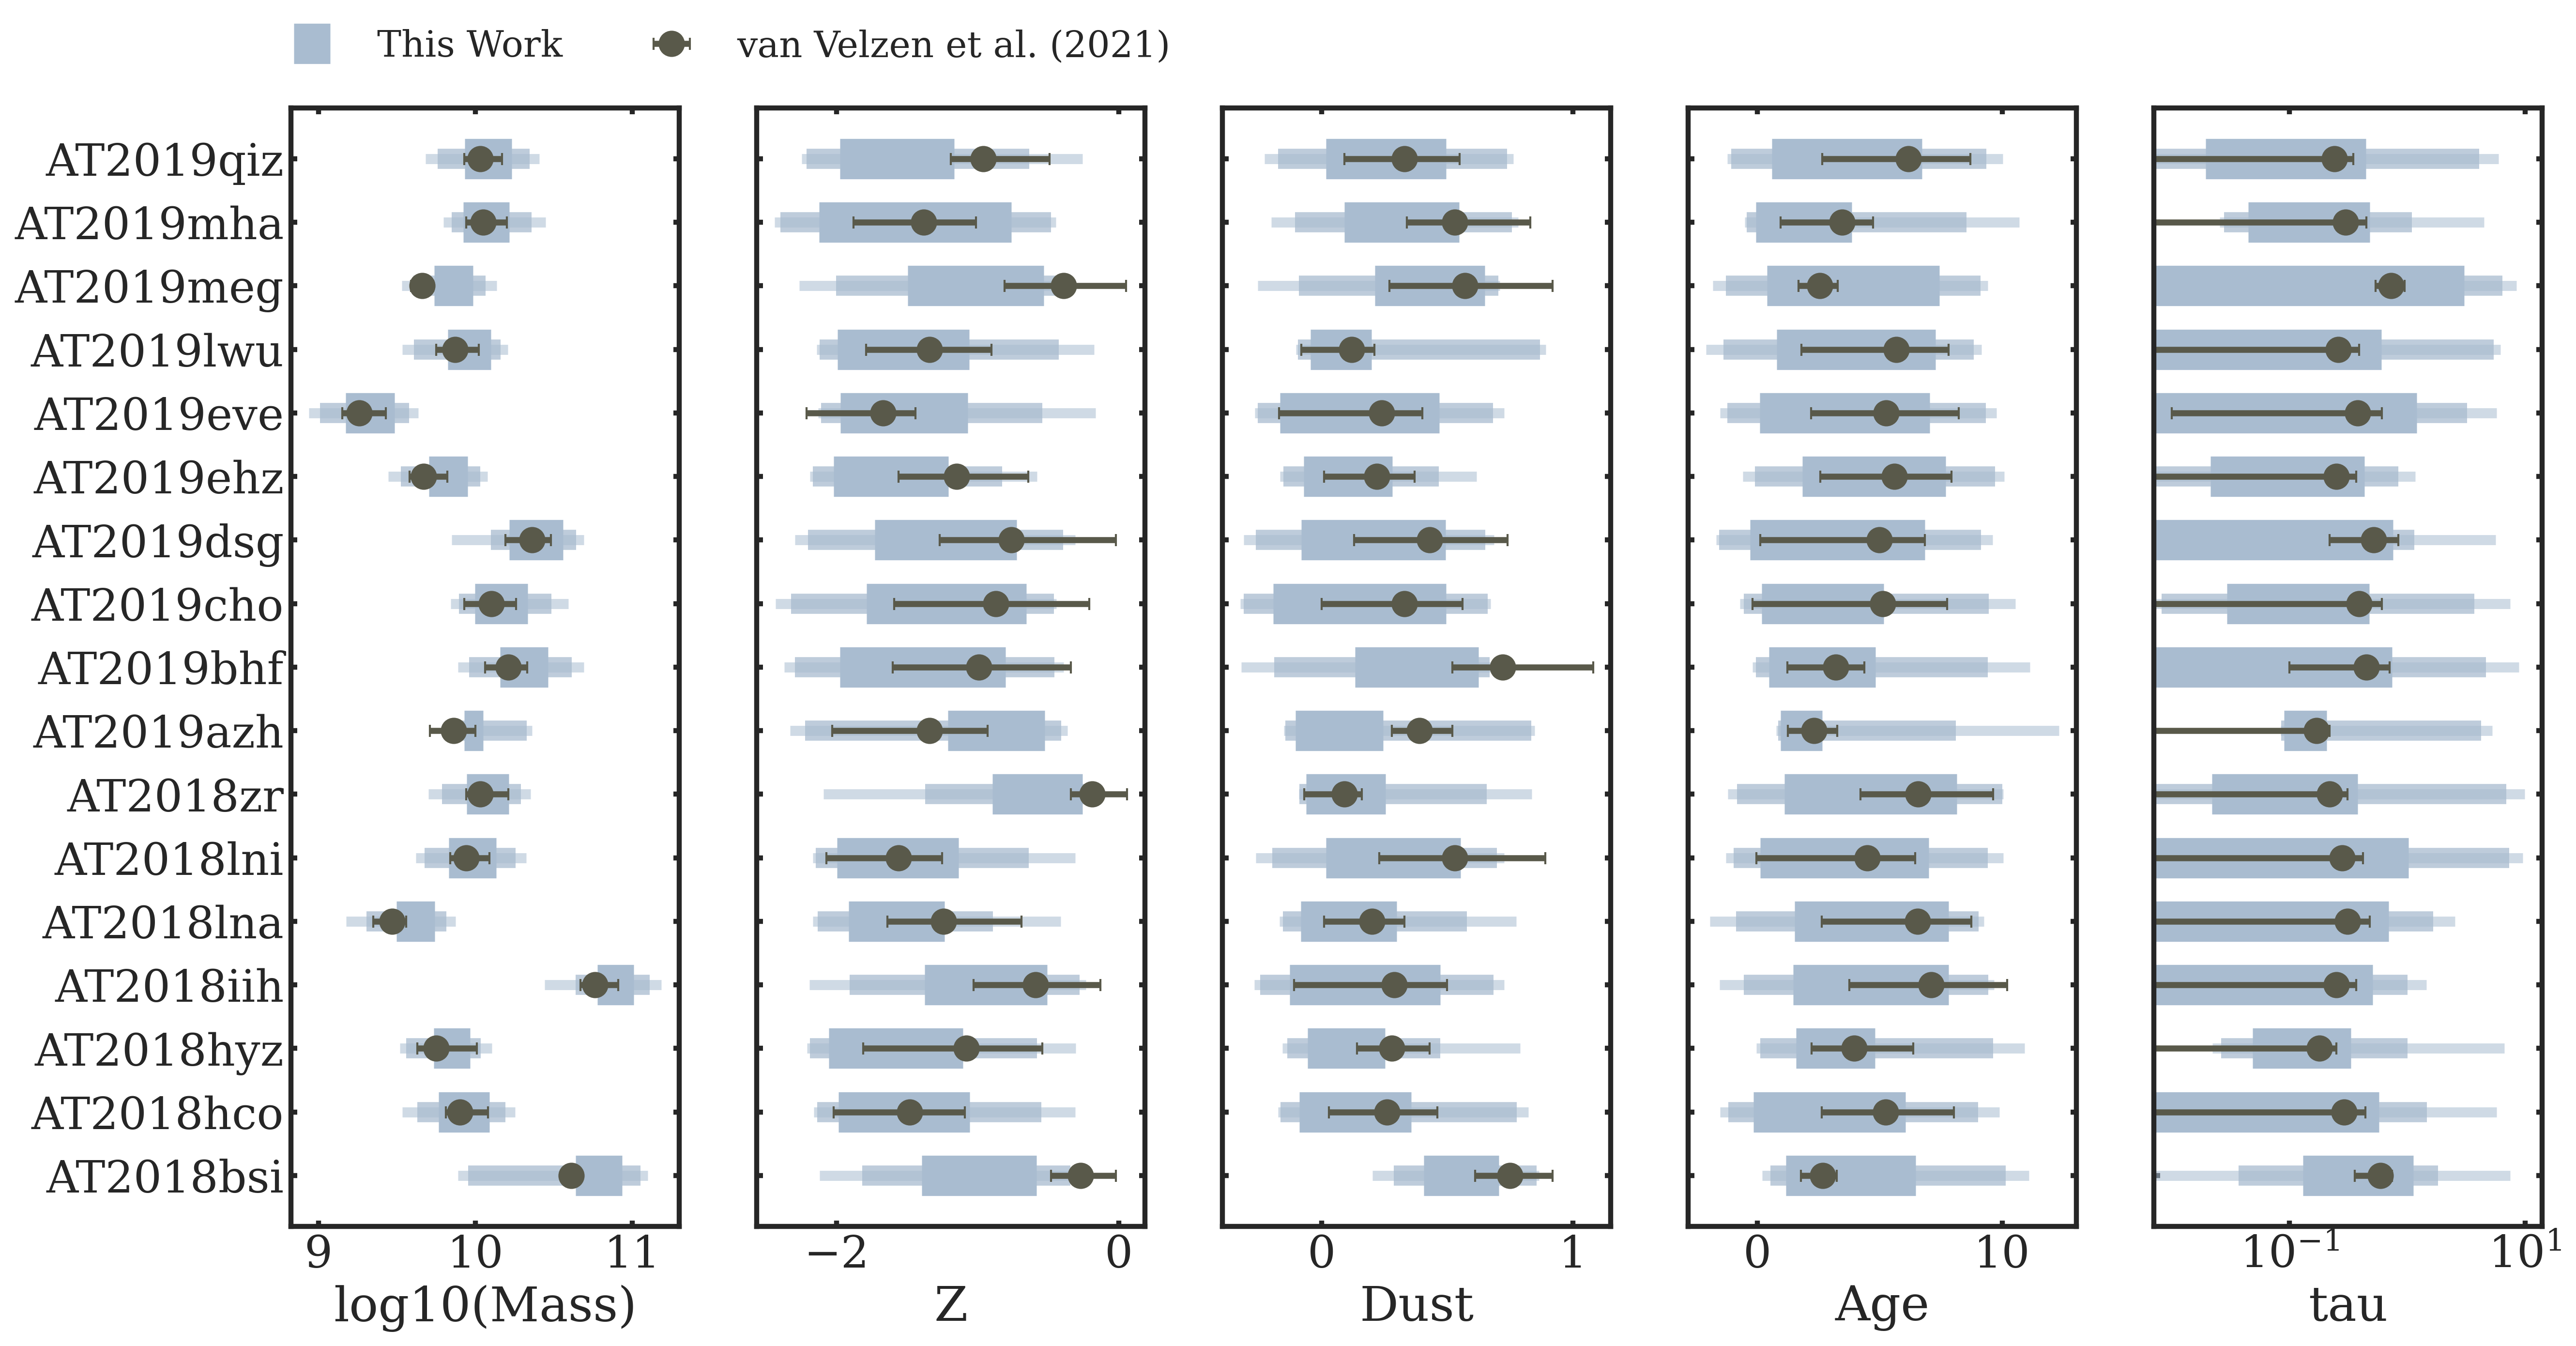

In [95]:
fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,10))
for ii, key in enumerate(comb):
    df = comb[key].sort_values('name', inplace=False)
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_1s, df.posErr_1s], fmt=myColor, label='This Work', elinewidth=20, marker=None, linestyle='None')
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_2s, df.posErr_2s], fmt=myColor, alpha=0.75, elinewidth=10, marker=None, linestyle='None')
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_3s, df.posErr_3s], fmt=myColor, alpha=0.55, elinewidth=5, marker=None, linestyle='None')
    #pos = list(range(len(df.name)))
    #print(len(pos))
    #print(len(df.median_Franz))
    #ax[ii].violinplot(df.median_Franz, pos)
    ax[ii].errorbar(df.median_vanVelzen, df.name, xerr=[df.negErr, df.posErr], color=vvColor, marker='o', linestyle='None', label='van Velzen et al. (2021)', capsize=3)
    ax[ii].set_xlabel(key)
    
ax[0].legend(ncols=2, bbox_to_anchor=(2.35,1.1), fontsize=18, frameon=False)
ax[-1].set_xscale('log')

# Try out a violin plot

Note! Something with the violin plot for log10 Mass is bugged with the errorbar conversion. 

In [96]:
subdict = {'name': [],
           'data': []
          }

dfdict = {'mass':deepcopy(subdict),
          'logzsol':deepcopy(subdict),
          'dust2':deepcopy(subdict),
          'tage':deepcopy(subdict),
          'tau':deepcopy(subdict)}

allkeys = list(dfdict.keys())
for key in allkeys:
    for name in alldata:

        dfdict[key]['name'].append(name)
        dfdict[key]['data'].append(alldata[name][key])

In [97]:
combviolin = {}
keys = ['log10(Mass)', 'Z', 'Dust', 'Age', 'tau']
for d, t, key in zip(dfdict.values(), true.values(), keys):
    newdata = pd.DataFrame(d)
    df = pd.merge(newdata, t, on='name', suffixes=['_Franz', '_vanVelzen']) 
    combviolin[key] = df

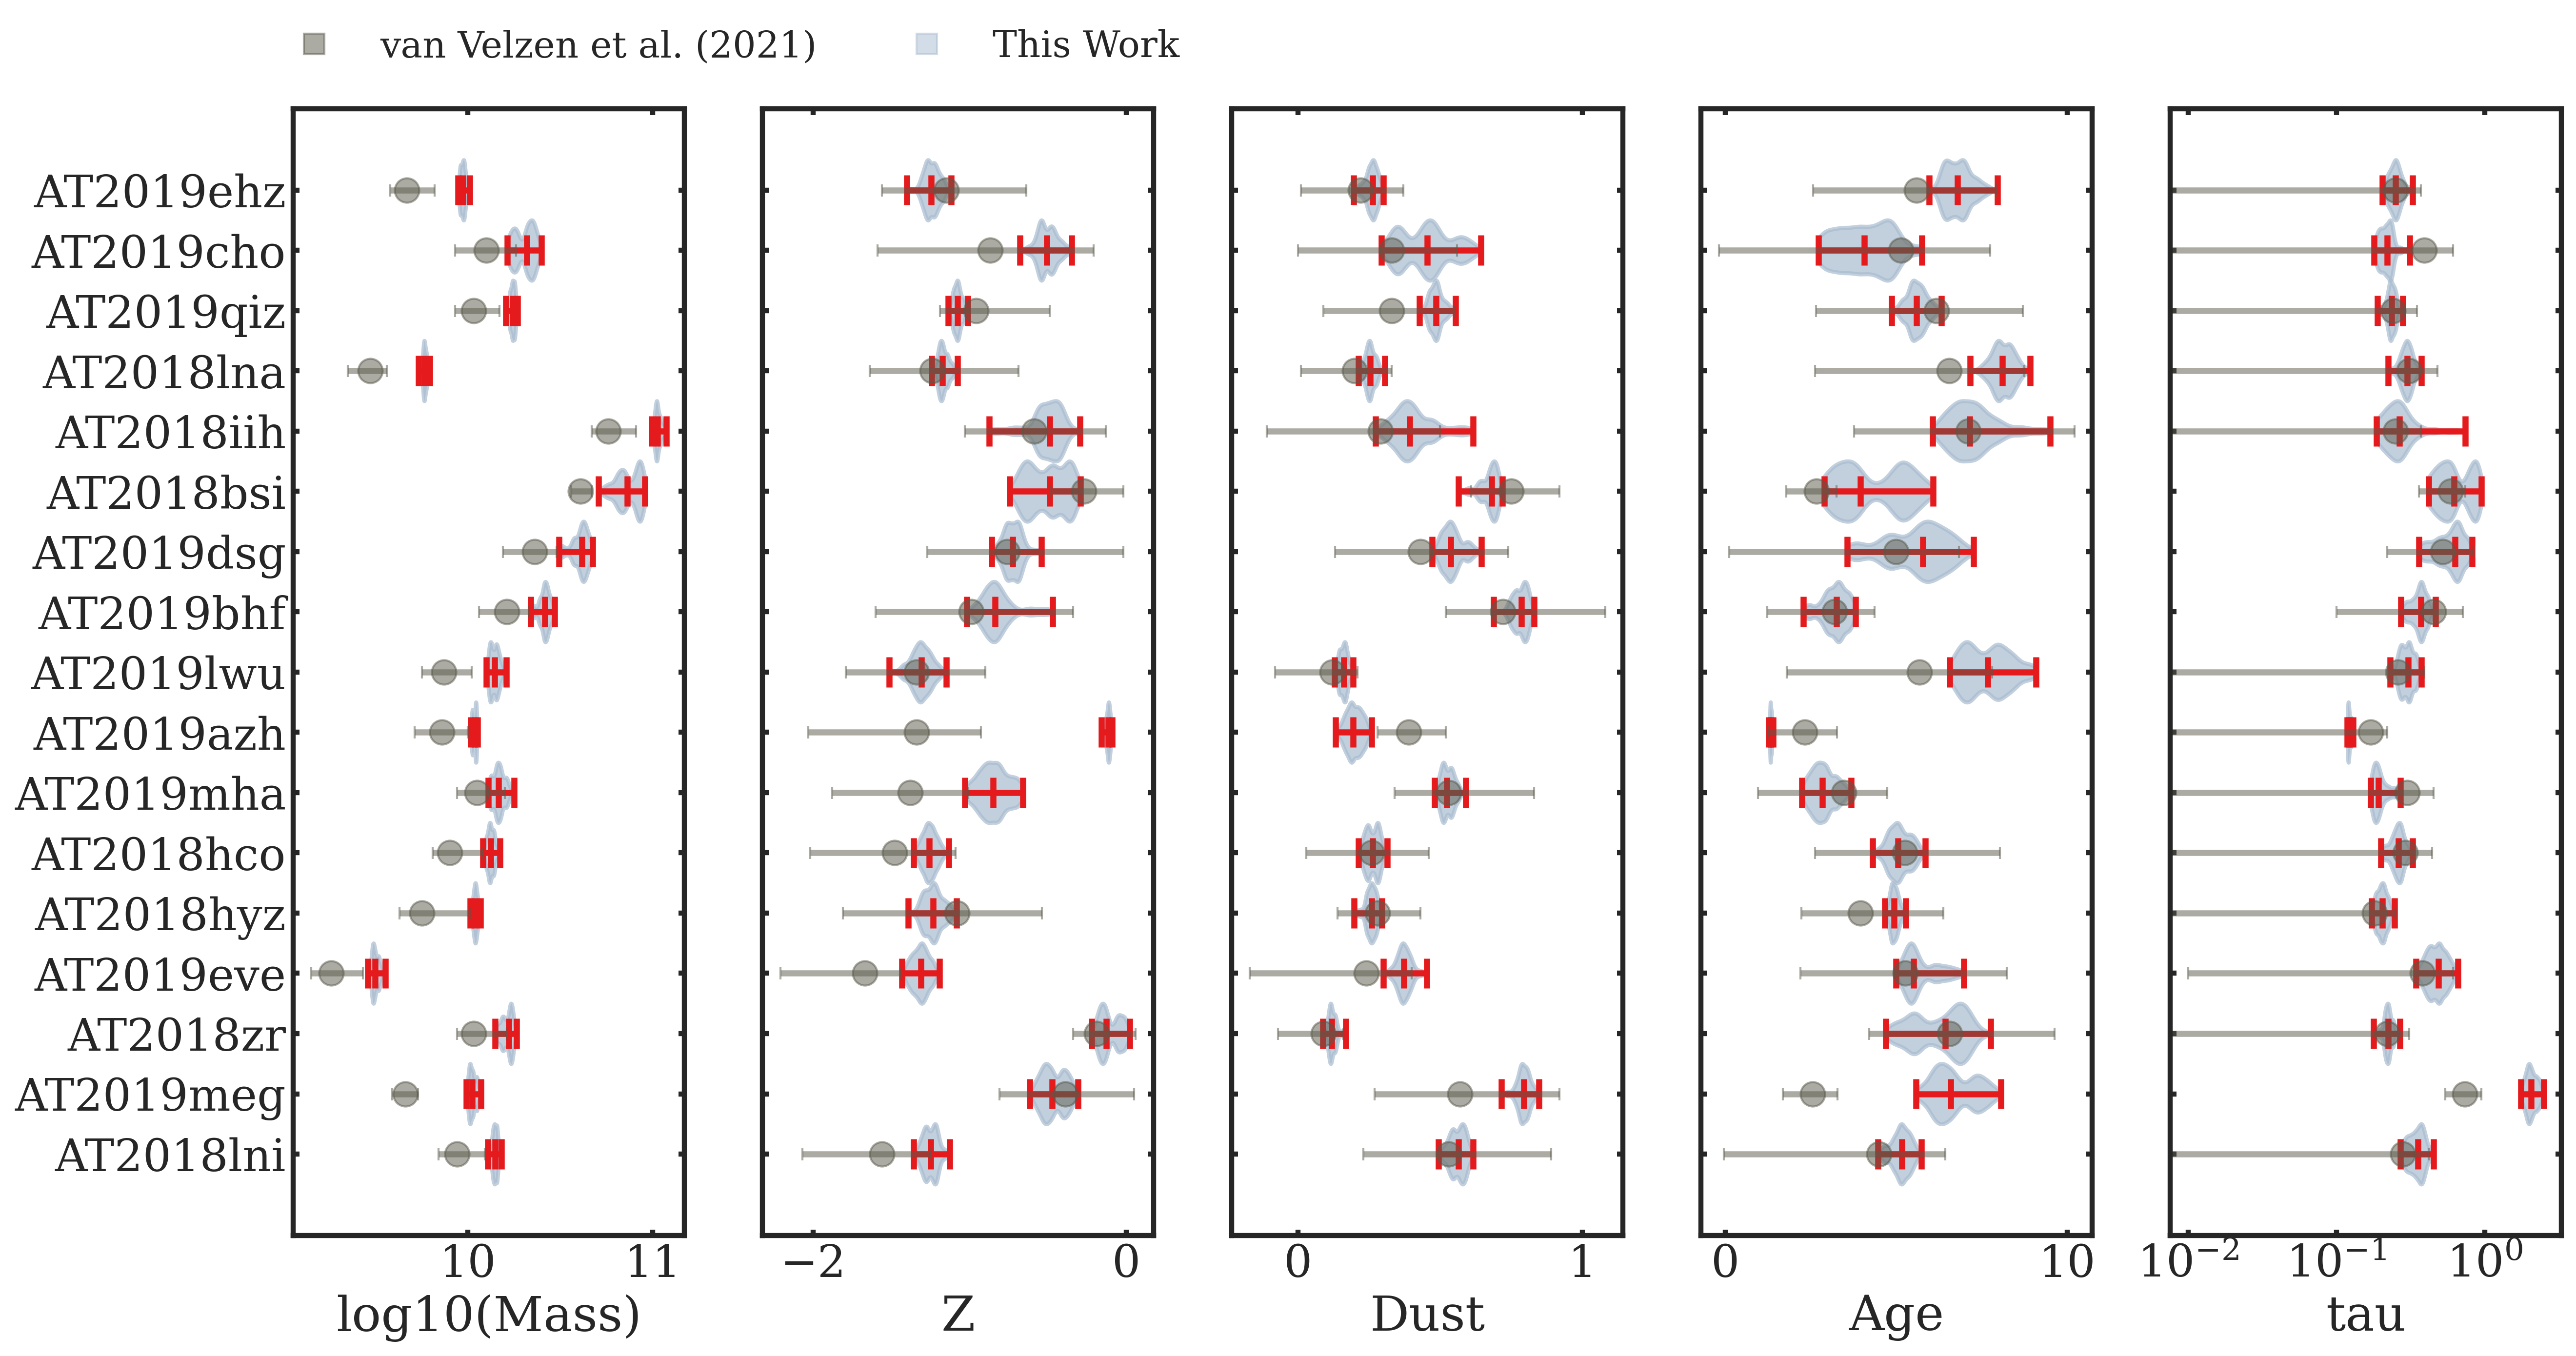

In [98]:
# Create a figure and axis
fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,10))

for ii, key in enumerate(combviolin):
    
    data = combviolin[key].data.values
    names = combviolin[key].name.values
    # Create a violin plot of my chains
    pos = list(range(len(names)))
    if key == 'log10(Mass)':
        toplot = [np.log10(d) for d in data]
    else:
        toplot = data
    parts = ax[ii].violinplot(toplot, pos, widths=1, showextrema=True, 
                              showmedians=True, vert=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(myColor)
        pc.set_edgecolor(myColor)
        pc.set_alpha(0.7)
    
    # overplot Sjoert's results        
    ax[ii].errorbar(combviolin[key]['median'], pos, xerr=[combviolin[key].negErr, combviolin[key].posErr], 
                   fmt='o', color=vvColor, label='van Velzen et al. (2021)', capsize=3, alpha=0.5)

    # Customize the plot as needed
    ax[ii].set_yticks(pos)
    ax[ii].set_xlabel(key)
    ax[ii].set_yticklabels(names)
    #ax[ii].set_xticks(ax[ii].get_xticks(), ax[ii].get_xticklabels(), rotation=45)

#ax[0].set_xscale('log')
ax[-1].set_xscale('log')
    
#plt.show()
ax[0].legend([Line2D([0],[0],color=vvColor, marker='s', linestyle='None', markersize=10, alpha=0.5), 
              Line2D([0], [0], color=myColor, marker='s', linestyle='None', markersize=10, alpha=0.5)], 
             ['van Velzen et al. (2021)', 'This Work'],
             ncols=2, bbox_to_anchor=(2.35,1.1), fontsize=18, frameon=False);

## Look at other results

In [99]:
# read in the json files

colordata = {'u-r color': [],
             'upper': [],
             'lower': [],
             'name': []}
for jfile in glob.glob('data/model/*.json'):
    with open(jfile, 'r') as j:
        data = json.load(j)
        #print(jfile)
        #print(data)
        #rint()
    colordata['u-r color'].append(data['u_r.0'][0])
    colordata['upper'].append(data['u_r.0'][1])
    colordata['lower'].append(data['u_r.0'][2])
    colordata['name'].append(os.path.basename(jfile).split('_')[0])
    
colordata = pd.DataFrame(colordata)    

colordata

,u-r color,upper,lower,name
0,1.854459,0.041627,0.035424,AT2018hyz
1,2.103462,0.023349,0.031103,AT2018bsi
2,2.190833,0.062171,0.082523,AT2019dsg
3,2.344918,0.047089,0.047763,AT2018iih
4,2.125283,0.057173,0.045486,AT2019cho
5,1.903272,0.057753,0.067365,AT2019lwu
6,1.974625,0.052795,0.062098,AT2018lni
7,1.810999,0.017652,0.038378,AT2019azh
8,1.937406,0.051714,0.076397,AT2019ehz
9,1.836869,0.052878,0.065920,AT2019eve


In [100]:
truecolor = {'u-r color': [],
             'upper': [],
             'lower': [],
             'name': np.array(truedata['name'])}

for color in truedata['u_r']:

    split1 = color.split('_')
    split2 = split1[1].split('^')

    med = split1[0][2:-1]
    if med[0] == '{':
        med = float(med.replace('{', '-'))
    else:
        med = float(med)

    upper = float(split2[0][1:-1])
    lower = float(split2[1][1:-2])
    
    truecolor['u-r color'].append(med)
    truecolor['upper'].append(upper)
    truecolor['lower'].append(lower)
    
truecolor = pd.DataFrame(truecolor)

truecolor

,u-r color,upper,lower,name
0,2.36,0.08,0.05,AT2018zr
1,2.17,0.04,0.03,AT2018bsi
2,1.88,0.07,0.06,AT2018hco
3,2.32,0.07,0.05,AT2018iih
4,1.91,0.03,0.05,AT2018hyz
5,1.97,0.08,0.09,AT2018lni
6,1.98,0.07,0.09,AT2018lna
7,2.08,0.07,0.10,AT2019cho
8,2.09,0.08,0.06,AT2019bhf
9,1.80,0.04,0.03,AT2019azh


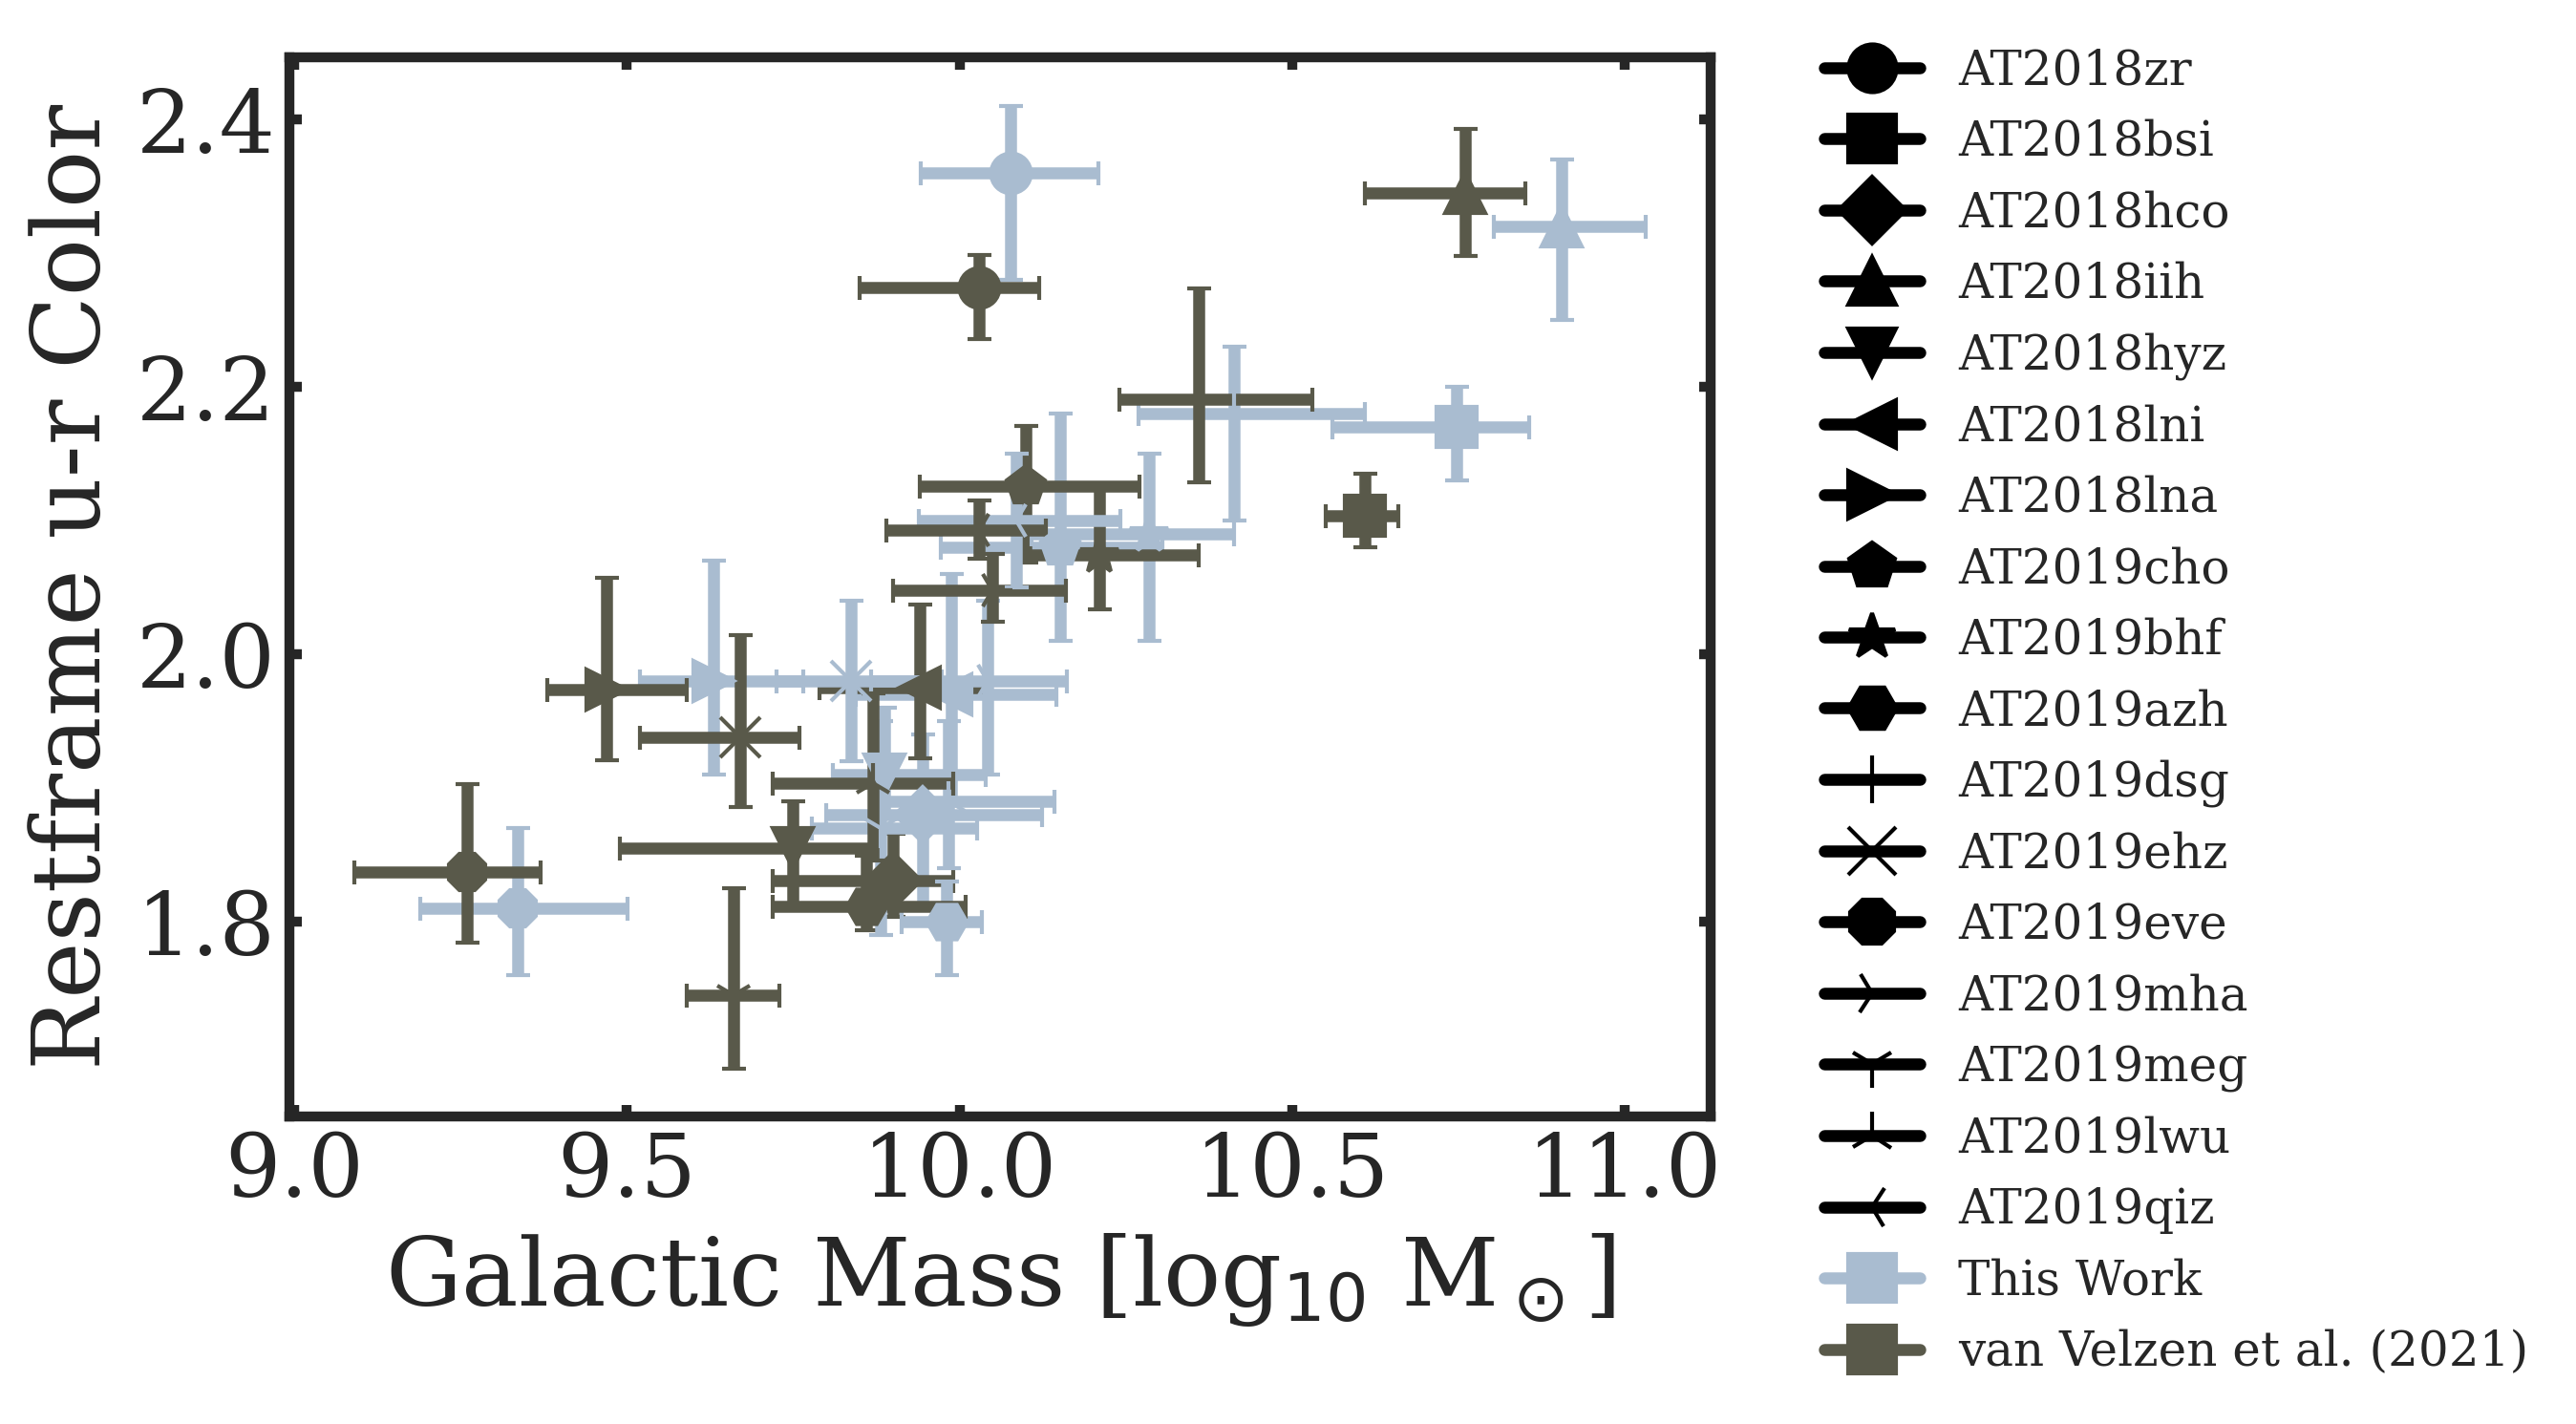

In [101]:
colors = pd.merge(truecolor, colordata, on='name', suffixes=['_Franz', '_vanVelzen']) 

colors['markers'] = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H', '+', 'x', '8', '4', '1', '2', '3']

colors = pd.merge(colors, comb['log10(Mass)'], on='name')

fig, ax = plt.subplots()
legendlines = []
for i, row in colors.iterrows():
    ax.errorbar([row['median_Franz']], [row['u-r color_Franz']], yerr=([row.upper_Franz], [row.lower_Franz]), 
                xerr=([row.posErr_1s], [row.negErr_1s]), marker=row.markers, color=myColor, capsize=3, markersize=10)
    ax.errorbar([row['median_vanVelzen']], [row['u-r color_vanVelzen']], yerr=([row.upper_vanVelzen], [row.lower_vanVelzen]), 
                xerr=([row.posErr], [row.negErr]), marker=row.markers, color=vvColor, capsize=3, markersize=10)
    legendlines.append(Line2D([0],[0],marker=row.markers,color='k'))
    
legendlines.append(Line2D([0], [0], marker='s', color=myColor))
legendlines.append(Line2D([0], [0], marker='s', color=vvColor))
    

#ax.set_ylim(0.75, 3)
#ax.set_xlim(8.5, 12)
ax.set_ylabel('Restframe u-r Color')
ax.set_xlabel(r'Galactic Mass [log$_{10}$ M$_\odot$]')
ax.legend(legendlines, list(colors.name)+['This Work', 'van Velzen et al. (2021)'], 
          bbox_to_anchor=(1.05, 1.05), frameon=False, ncols=1, fontsize=12);

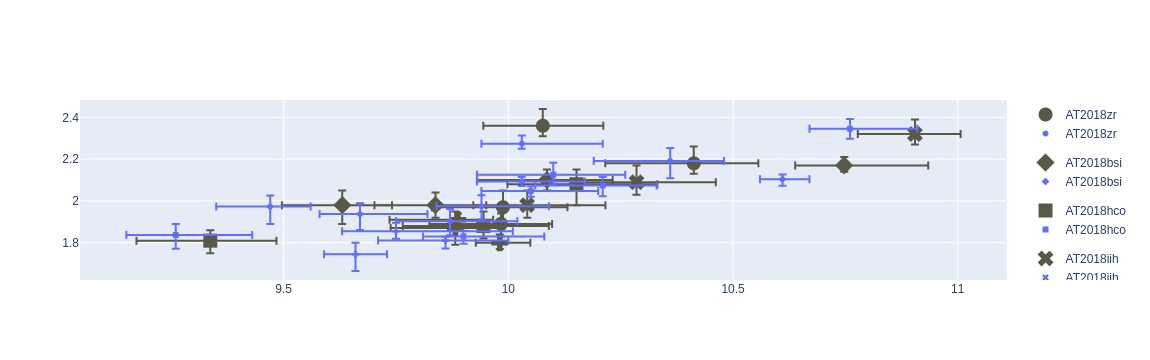

In [102]:
import plotly.express as px
import plotly.graph_objects as go
ms = 14

fig1 = px.scatter(colors, x='median_Franz', y='u-r color_Franz',
                  error_x='posErr_1s', error_x_minus='negErr_1s', 
                  error_y='upper_Franz', error_y_minus='lower_Franz',
                  symbol='name')
fig1.update_traces(marker={'color': myColor, 'size':ms})

fig2 = px.scatter(colors, x='median_vanVelzen', y='u-r color_vanVelzen',
                 error_x='posErr', error_x_minus='negErr', 
                 error_y='upper_vanVelzen', error_y_minus='lower_vanVelzen',
                 symbol='name')
fig1.update_traces(marker={'color': vvColor, 'size':ms})

go.Figure(data=fig1.data+fig2.data)

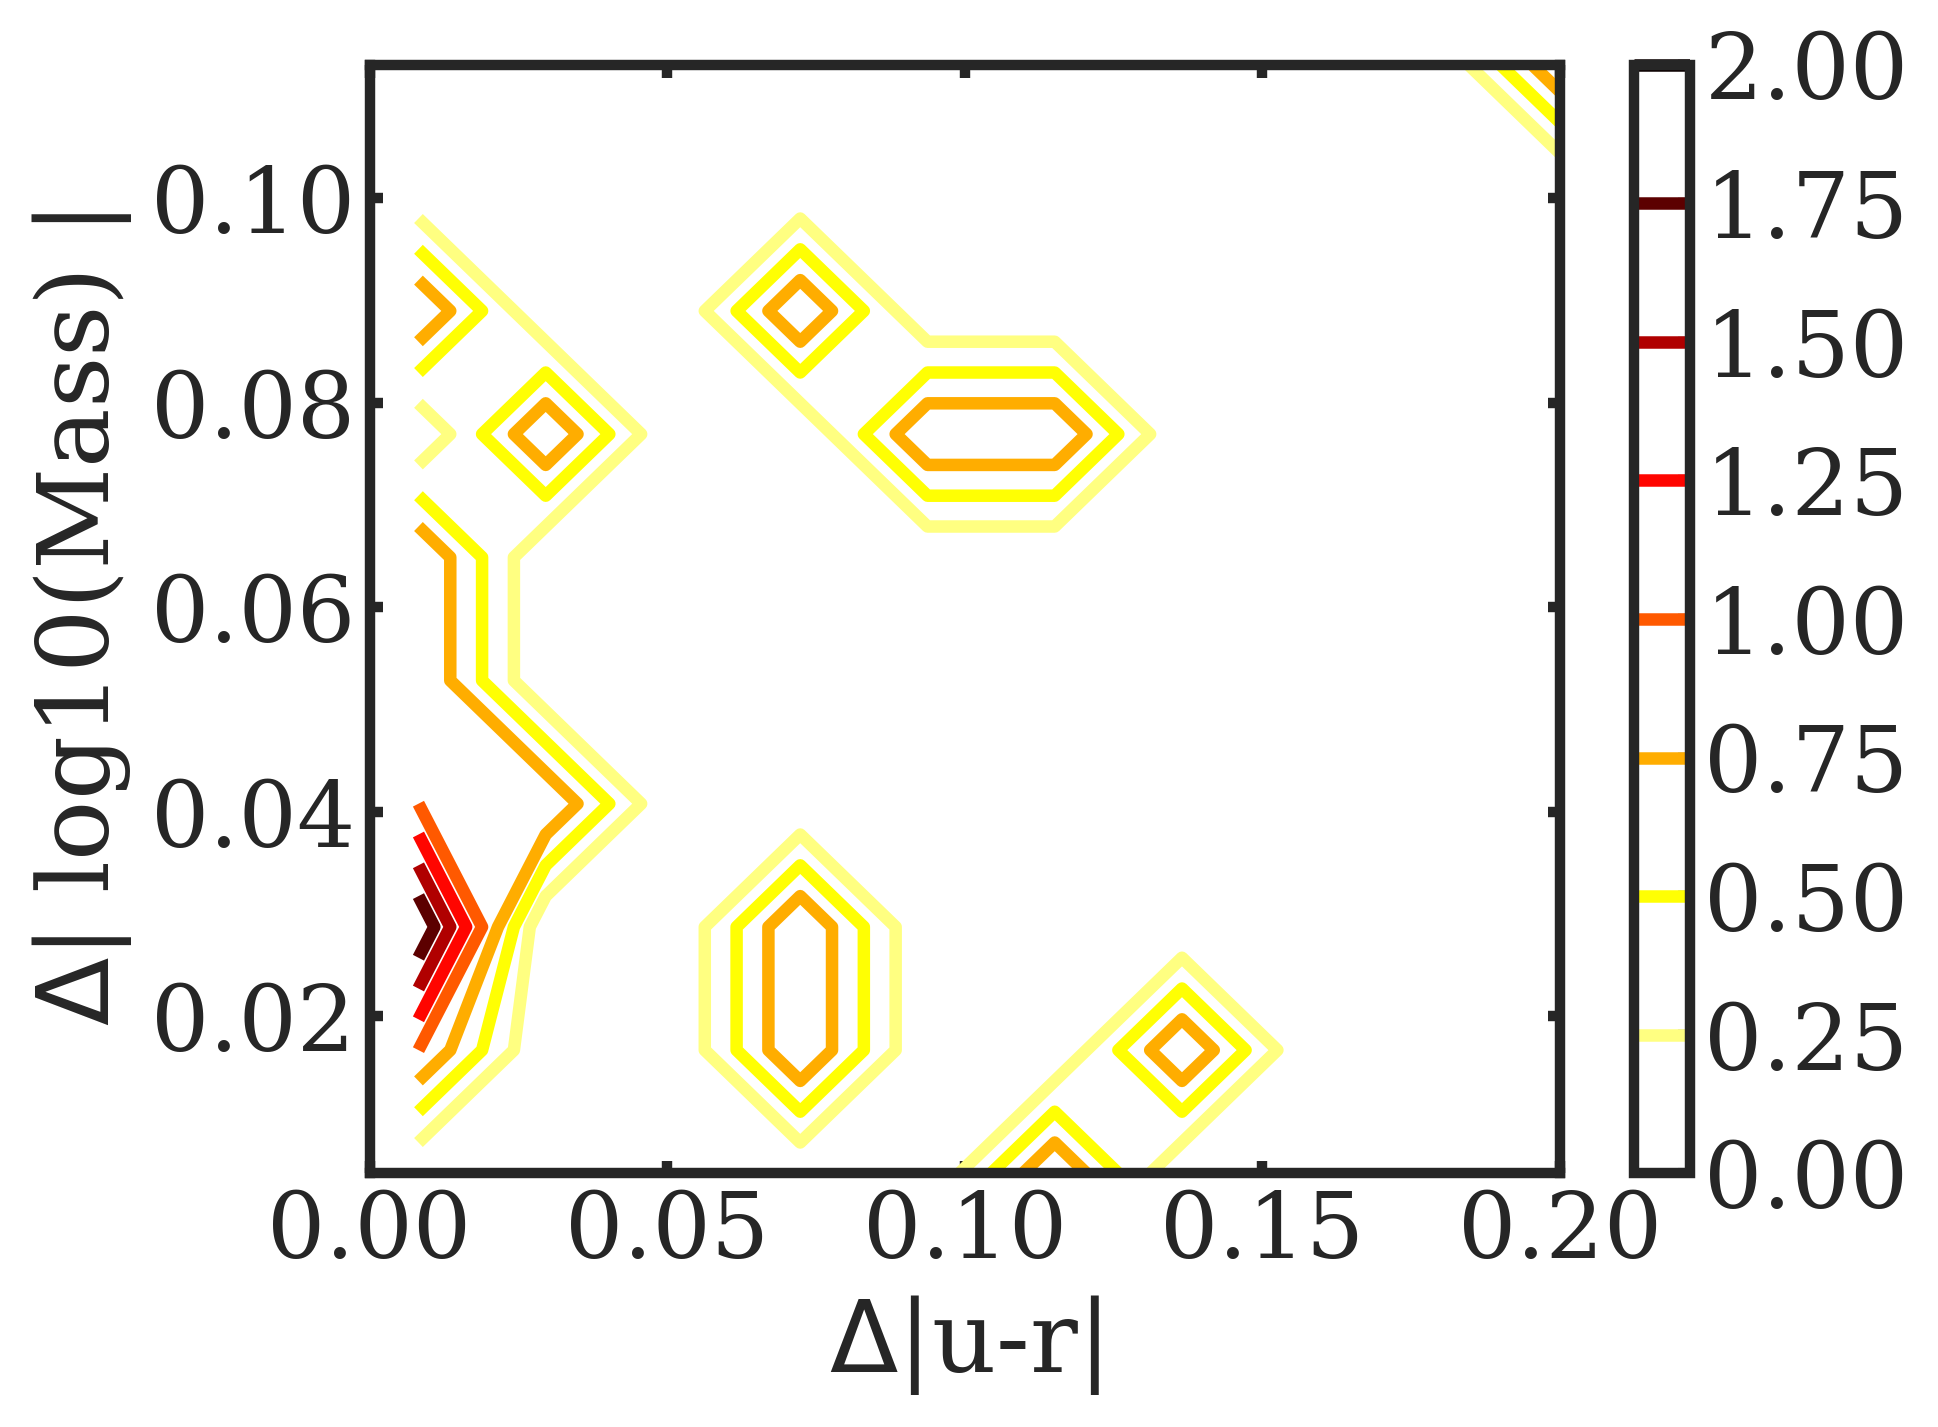

In [103]:
# plot differences in the distributions

fig, ax = plt.subplots()
#_, _, _, cmap = ax.hist2d(abs(colors.median_Franz-colors.median_vanVelzen), 
          #abs(colors['u-r color_Franz']-colors['u-r color_vanVelzen']),
         #cmap='hot_r')
bins, x, y = np.histogram2d(abs(colors.median_Franz-colors.median_vanVelzen), 
          abs(colors['u-r color_Franz']-colors['u-r color_vanVelzen']))
out = ax.contour(x[:-1],y[:-1],bins,cmap='hot_r')
ax.set_xlabel(r'$\Delta$|u-r|')
ax.set_ylabel(r'$\Delta$| log10(Mass) |')
ax.set_xlim(0, 0.2)
fig.colorbar(out, ax=ax)

# look for correlations

In [104]:
hdr = ['name', 'Lg', 'Lbb', 'T', 'dTdt', 'tpeak_norm', 'sigma', 'tau', 'p', 't0']
tdeprops = pd.read_csv('data/tde_props.txt', delimiter='\t', skiprows=2, 
                       names=hdr, usecols=range(10), index_col=None)

In [203]:
# combine all the relevant data
tdepropnames = ['T', 'Lbb', 'sigma', 'tau', 'name'] # sigma=gaussian rise time, tau=exponential decay time
galaxypropnames = ['u-r color_Franz', 'name', 'median_Franz']

redshifts = pd.read_csv('data/redshifts.tsv', delimiter='\t')
redshifts['name'] = redshifts['IAU Name']
redshifts = redshifts[['name', 'Redshift']]

data = pd.merge(redshifts, pd.merge(tdeprops[tdepropnames], colors[galaxypropnames], on='name'), on='name')

# rename some columns to match the paper
data['Host u-r'] = data['u-r color_Franz']
data['Host Mass'] = data['median_Franz']
data['L_bb'] = data['Lbb']
data['Rise Time'] = data['sigma']
data['Decay Time'] = data['tau']
data['z'] = data['Redshift']

data = data.drop(['u-r color_Franz', 'median_Franz', 'Lbb', 'sigma', 'tau', 'Redshift'], axis=1)

# extract the medians from the latex source
def med(row, key):
    if row[key] == 'cdots':
        return np.nan
    else:
        return float(row[key].split('_')[0][2:-1])

data['T'] = 10**data.apply(med, axis=1, key='T')
data['L_bb'] = 10**data.apply(med, axis=1, key='L_bb')
data['Rise Time'] = 10**data.apply(med, axis=1, key='Rise Time')
data['Decay Time'] = 10**data.apply(med, axis=1, key='Decay Time')

# compute the blackbody radius
R = np.sqrt((np.array(data.L_bb)*u.erg/u.s) / (const.sigma_sb.cgs * 4 * np.pi * (np.array(data['T'])*u.K)**4))
data['R'] = R.value


In [204]:
paper_order = ['R', 'T', 'L_bb', 'Rise Time', 'Decay Time', 'z', 'Host Mass', 'Host u-r']
pvalues = {col:{col2:np.nan for col2 in paper_order if col2 != 'name'} for col in paper_order if col != 'name'}

for ii, col1 in enumerate(data[paper_order]):
    for jj, col2 in enumerate(data[paper_order]):
        if col1 == 'name' or col2 == 'name': continue
        if ii > jj and ii != jj:
            
            nonans = data[[col1, col2]].dropna()
            
            out = kt(nonans[col1], nonans[col2])
            
            pvalues[col1][col2] = out.pvalue

pvalues_out = pd.DataFrame(pvalues)

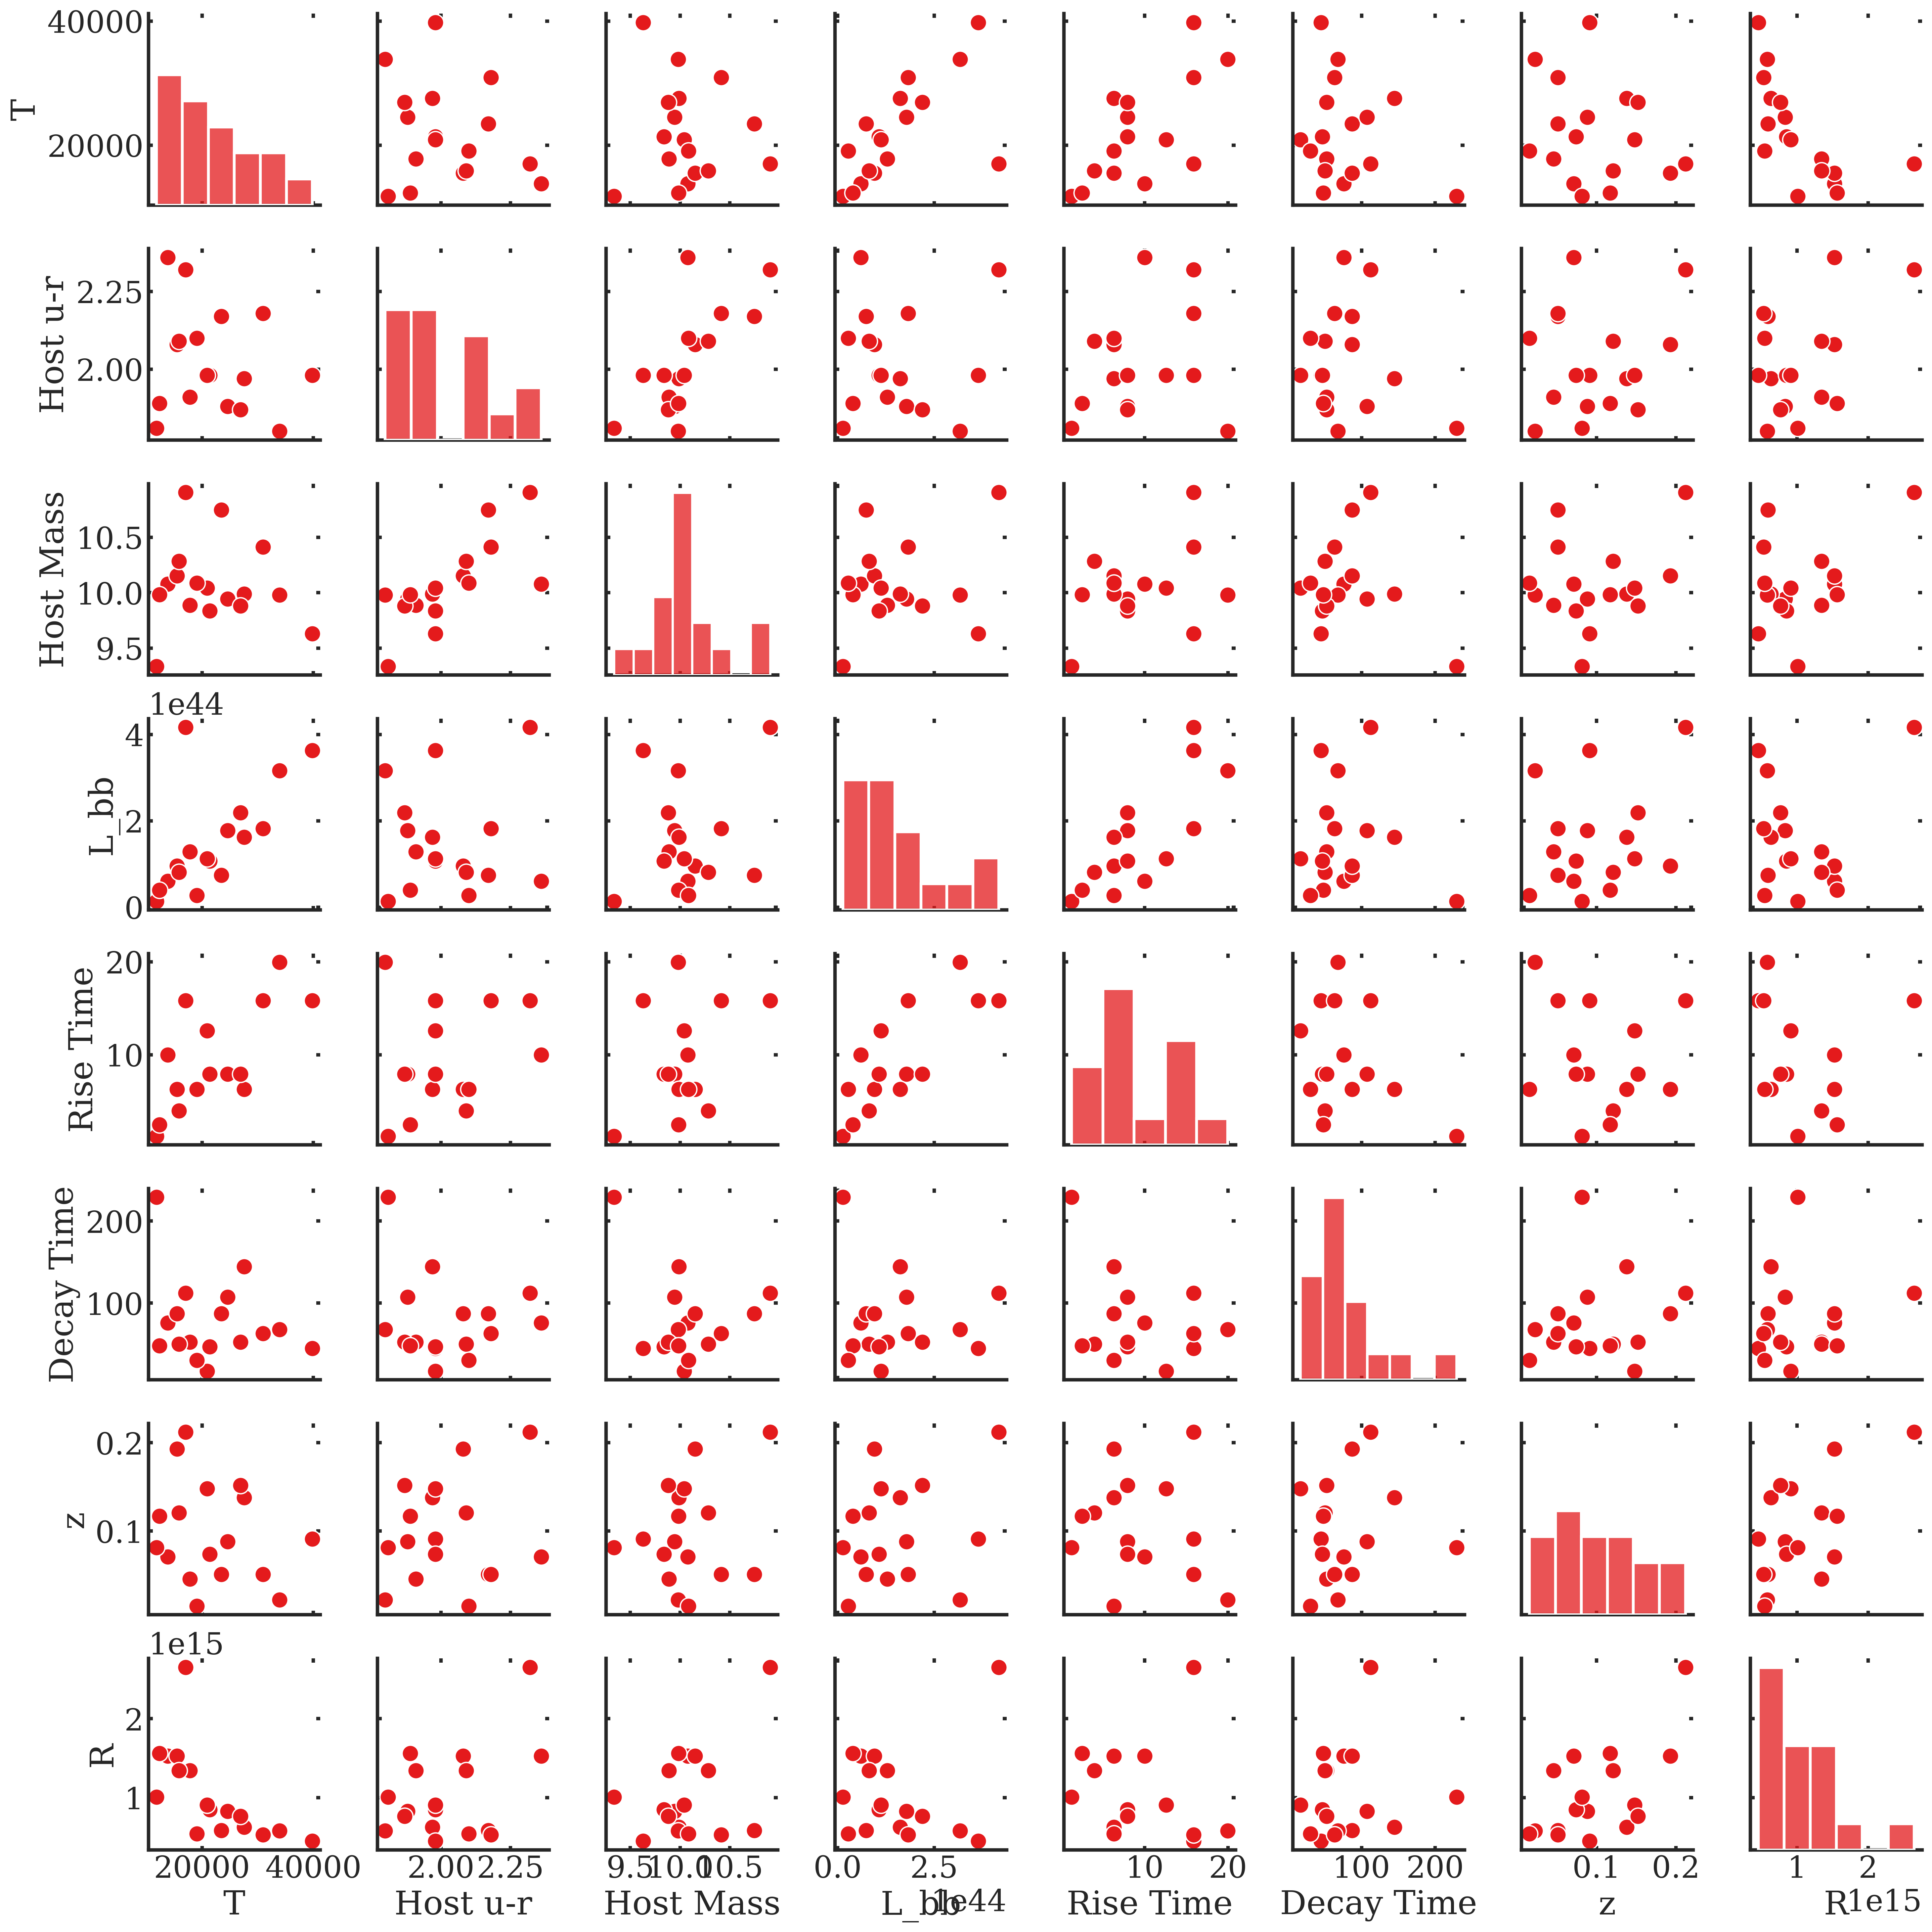

In [205]:
sns.pairplot(data)

In [206]:
pvalues_out_image = pvalues_out.style.background_gradient(cmap='binary').applymap(
    lambda x: 'background-color: black; color:white' if np.isnan(x) else ''
)
dfi.export(pvalues_out_image, 'pvalues.png')

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning:

All-NaN slice encountered

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning:

All-NaN slice encountered



In [207]:
pvalues_out_image

,R,T,L_bb,Rise Time,Decay Time,z,Host Mass,Host u-r
R,nan,0.000052,0.151334,0.269730,0.363995,0.091386,0.655308,0.649444
T,nan,nan,0.000629,0.009088,0.679880,0.597644,0.655308,0.535376
L_bb,nan,nan,nan,0.000929,0.741323,0.308115,0.776494,0.385532
Rise Time,nan,nan,nan,nan,0.615896,0.688170,0.688170,0.449794
Decay Time,nan,nan,nan,nan,nan,0.457646,0.409227,0.709510
z,nan,nan,nan,nan,nan,nan,0.715032,0.772390
Host Mass,nan,nan,nan,nan,nan,nan,nan,0.001097
Host u-r,nan,nan,nan,nan,nan,nan,nan,nan


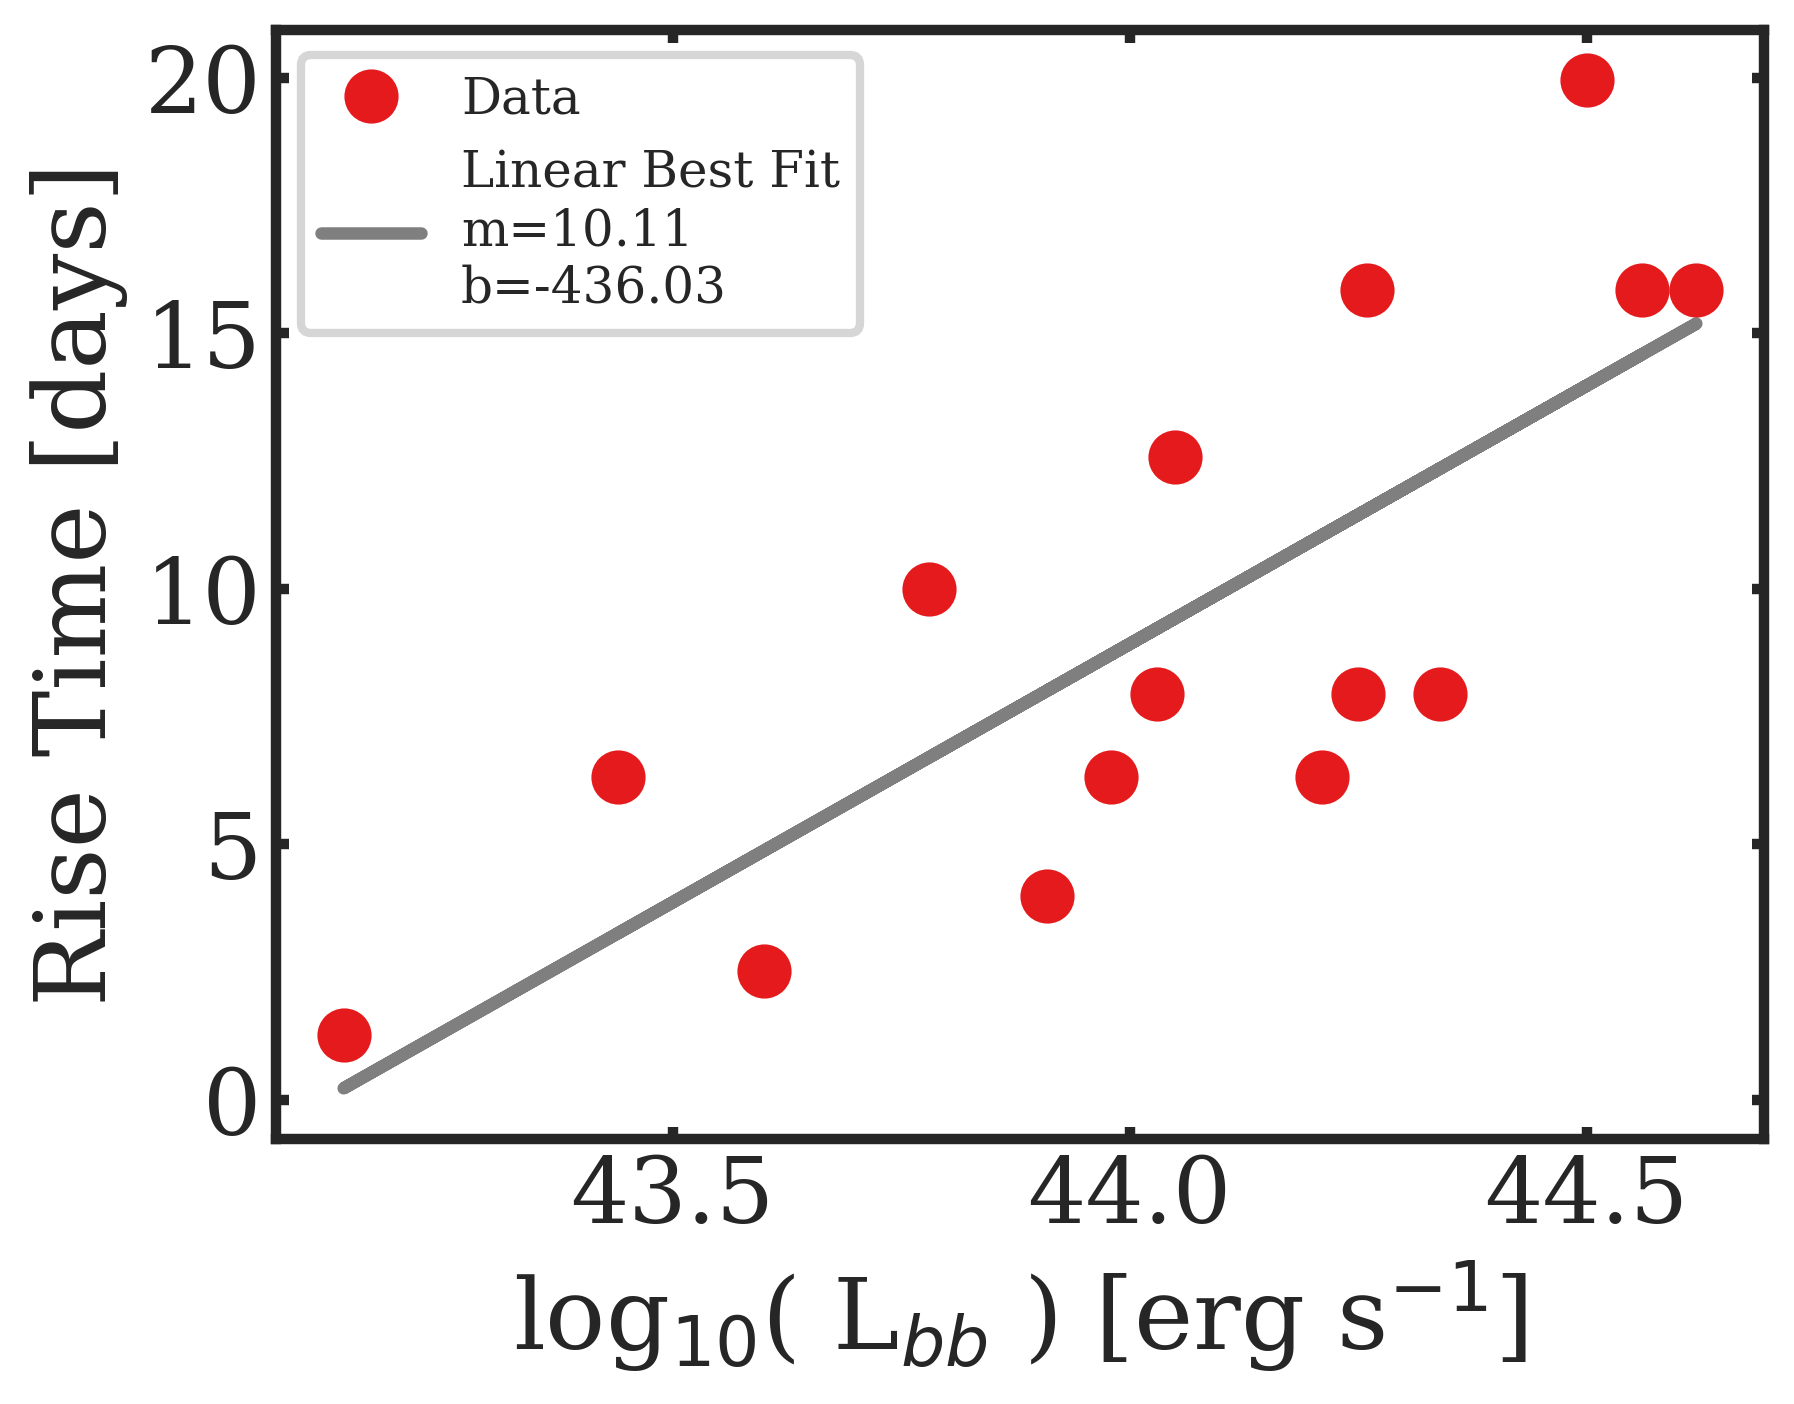

In [232]:
# plot just the Rise Time vs. L_bb

data_nonan = data.dropna()

x, y = np.log10(data_nonan.L_bb), data_nonan['Rise Time']

fig, ax = plt.subplots()
ax.plot(x, y, 'o', label='Data')

m, b = np.polyfit(x,y,1)
ax.plot(x, m*x+b, 'k-', label=f'Linear Best Fit\nm={m:.2f}\nb={b:.2f}', alpha=0.5)
ax.set_ylabel('Rise Time [days]')
ax.set_xlabel(r'log$_{10}$( L$_{bb}$ ) [erg s$^{-1}$]')
ax.legend(fontsize=12)

In [210]:
pvalues_out

,R,T,L_bb,Rise Time,Decay Time,z,Host Mass,Host u-r
R,NaN,0.000052,0.151334,0.269730,0.363995,0.091386,0.655308,0.649444
T,NaN,NaN,0.000629,0.009088,0.679880,0.597644,0.655308,0.535376
L_bb,NaN,NaN,NaN,0.000929,0.741323,0.308115,0.776494,0.385532
Rise Time,NaN,NaN,NaN,NaN,0.615896,0.688170,0.688170,0.449794
Decay Time,NaN,NaN,NaN,NaN,NaN,0.457646,0.409227,0.709510
z,NaN,NaN,NaN,NaN,NaN,NaN,0.715032,0.772390
Host Mass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001097
Host u-r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
